Import all packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

# Stress Enhanced FearLearning - Freezing Analysis

Stress-enhanced fear learning (SEFL) is a Pavlovian behavioral paradigm used to model pathological anxiety and fear overgeneralization. The SEFL protocol was developed by the Fanselow group to recapitulate critical aspects of PTSD including long-term sensitization of fear learning caused by an acute stressor (Rau et al. 2005; Au - Rajbhandari et al 2018). On Day 1, mice receive 4 randomly-timed footshocks (1 mA, 2s, average ISI = 180 seconds) in Context A. On Day 2, mice are placed back in Context A, and freezing behavior in the aversive context is measured for 5 minutes. On Day 3, mice are placed in a separate Context B and delivered a mild stressor consisting of a novel tone given after a 180-s baseline period. The “trauma” procedure on Day 1 in Context A will enhance the fear response for the mild stressor administered in Context B. Mice show minimal fear generalization from the traumatic context but show increased fear response in the context where the mild stressor was administered.

In these experiments, we are testing whether previous experience of early life stress (ELS), using the limited bedding and nesting (LBN) model, affects the development of persistent fear overgeneralization. Animals reared under ELS or control (Ctrl) conditions will be assessed for their freezing during Context A training and testing as well as in Context B to a mild stressor. 

The software used to assess the freezing behavior (Ethovision) measures the animals’ time immobile across time bins for each arena and outputs an anonymized wide format data frame. We will convert this into long format and merge with metadata about each individual for subsequent group comparisons. 

## Convert dataframe from default Ethovision output

### Import (default) ethovision export file from inactivity analysis

Based on the original structure of the data output, I import with multiindexing to allow for Arena and Freezing thresholds to become columns later on. 

In [2]:
etho_df = pd.read_csv('SEFL_Inactivity_Cohort_1.csv',header = [3,4])

In [3]:
etho_df #examine data frame

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Arena 1,Arena 2,Arena 3,Arena 4,Arena 1,Arena 2,Arena 3,Arena 4,Arena 1,Arena 2,Arena 3,Arena 4
,Unnamed: 0_level_1,Unnamed: 1_level_1,Unnamed: 2_level_1,.10freeze,.10freeze,.10freeze,.10freeze,.05freeze,.05freeze,.05freeze,.05freeze,.03freeze,.03freeze,.03freeze,.03freeze
0,Trial 1,ContextAtraining,0:00:00-0:00:30,2.12,6.00,5.04,5.68,0.96,2.08,3.40,3.60,0.16,0.80,2.76,2.28
1,Trial 1,ContextAtraining,0:00:30-0:01:00,2.96,6.28,10.84,8.48,1.24,3.80,8.44,5.52,0.64,2.28,6.60,3.48
2,Trial 1,ContextAtraining,0:01:00-0:01:30,4.80,3.24,7.40,10.56,3.04,1.08,3.48,7.56,1.80,0.64,2.32,5.72
3,Trial 1,ContextAtraining,0:01:30-0:02:00,10.28,1.68,10.20,11.44,7.16,0.24,5.56,8.20,5.68,0.16,3.32,6.36
4,Trial 1,ContextAtraining,0:02:00-0:02:30,6.60,2.96,15.08,1.40,3.56,1.64,8.96,0.72,2.40,0.84,6.36,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Trial 39,ContextBTest,0:01:30-0:02:00,8.16,9.72,NaN,NaN,6.88,7.08,NaN,NaN,6.32,5.68,NaN,NaN
378,Trial 39,ContextBTest,0:02:00-0:02:30,18.16,7.36,NaN,NaN,15.48,3.52,NaN,NaN,13.56,2.52,NaN,NaN
379,Trial 39,ContextBTest,0:02:30-0:03:00,18.12,3.72,NaN,NaN,13.24,1.80,NaN,NaN,10.92,1.36,NaN,NaN


Here, we rename the unnammed columns to something useful and discard the lower level

In [4]:
etho_df = etho_df.rename(columns={"Unnamed: 0_level_0": "Trial", 
                                  "Unnamed: 1_level_0": "Experiment",
                                  "Unnamed: 2_level_0": "Time_Bin",
                                  "Unnamed: 0_level_1": None,
                                  "Unnamed: 1_level_1": None,
                                  "Unnamed: 2_level_1": None                                 
                                 })

You'll see that there are 3 different freezing thresholds that have been collected. For the sake of simplicity, we will drop all but the most stringent setting `.03freeze`. (Would be nice for functionality to turn this into a function/selector for which freezing threshold using if/else)

In [5]:
etho_df_03 = etho_df.drop(columns = ['.10freeze', '.05freeze'], level = 1)

Now, we melt the table so that `Arena` becomes it's own column and the freezing duration is distributed between them for each animal 

In [6]:
etho_melt = etho_df_03.melt(col_level=0,
    id_vars=['Trial', 'Experiment', 'Time_Bin'],#columns to keep 
    var_name= 'Arena', #new column name
    value_name= 'freezing_duration(s)' #new column for freezing
)

### Calculate Percent Freezing for each time bin

Here, we add a column for the length of each bout (30 seconds). Eventually would like to be able to derive this from the time stamp. 

In [7]:
etho_melt.insert(5,"Bout(s)", 30) #same insert as above, adding to far right

Add a new column called `% Freezing` that takes `freezing duration (s)` divided by `Bout (s)` and multiply by 100.

In [9]:
etho_melt["PcentFreezing"] = (etho_melt['freezing_duration(s)']/ etho_melt['Bout(s)'])*100

Using the `Time_Bin` column, generate a new column called `Time(s)` containing the time bin total in seconds with a `for` loop. Considered converting to timedelta but...did not work.

In [10]:
result = []
for string in etho_melt['Time_Bin']:
    if string == '0:00:00-0:00:30':
        result.append(30)
    elif string == '0:00:30-0:01:00':
        result.append(60)
    elif string == '0:01:00-0:01:30':
        result.append(90)
    elif string == '0:01:30-0:02:00':
        result.append(120)
    elif string == '0:02:00-0:02:30':
        result.append(150)
    elif string == '0:02:30-0:03:00':
        result.append(180)
    elif string == '0:03:00-0:03:30':
        result.append(210)
    elif string == '0:03:30-0:04:00':
        result.append(240)
    elif string == '0:04:00-0:04:30':
        result.append(270)
    elif string == '0:04:30-0:05:00':
        result.append(300)
    elif string == '0:05:00-0:05:30':
        result.append(330)
    elif string == '0:05:30-0:06:00':
        result.append(360)
    elif string == '0:06:00-0:06:30':
        result.append(390)        
    elif string == '0:06:30-0:07:00':
        result.append(420)
    elif string == '0:07:00-0:07:30':
        result.append(450)
    else: 
        result.append('NaN')
    
etho_melt['Time(s)'] = result
etho_melt

,Trial,Experiment,Time_Bin,Arena,freezing_duration(s),Bout(s),PcentFreezing,Time(s)
0,Trial 1,ContextAtraining,0:00:00-0:00:30,Arena 1,0.16,30,0.533333,30
1,Trial 1,ContextAtraining,0:00:30-0:01:00,Arena 1,0.64,30,2.133333,60
2,Trial 1,ContextAtraining,0:01:00-0:01:30,Arena 1,1.80,30,6.000000,90
3,Trial 1,ContextAtraining,0:01:30-0:02:00,Arena 1,5.68,30,18.933333,120
4,Trial 1,ContextAtraining,0:02:00-0:02:30,Arena 1,2.40,30,8.000000,150
...,...,...,...,...,...,...,...,...
1523,Trial 39,ContextBTest,0:01:30-0:02:00,Arena 4,NaN,30,NaN,120
1524,Trial 39,ContextBTest,0:02:00-0:02:30,Arena 4,NaN,30,NaN,150
1525,Trial 39,ContextBTest,0:02:30-0:03:00,Arena 4,NaN,30,NaN,180
1526,Trial 39,ContextBTest,0:03:00-0:03:30,Arena 4,NaN,30,NaN,210


In a later step `merge`, we identified a couple issues with some `Trial` strings containing additional spaces. We remove them here using the `replace` function. 

In [11]:
etho_shrink = etho_melt.replace('Trial     ', 'Trial ', regex=True) # replace 5 spaces with one, using regular expresion
etho_shrink2 = etho_shrink.replace('Trial    ', 'Trial ', regex=True) #replace the 4 additional spaces with 1

In [12]:
etho_shrink2['Trial'].iloc[0] # check if 5 space has changed

'Trial 1'

In [13]:
etho_shrink2['Trial'].iloc[80] # check if  4 space has changed

'Trial 6'

Several rows also contain NaN because they are empty arenas with out any freezing data, we drop those with `dropna`. 

In [14]:
etho_tidy = etho_shrink2.dropna(axis = 'rows') #requires axis to keep in DataFrame format
etho_tidy

,Trial,Experiment,Time_Bin,Arena,freezing_duration(s),Bout(s),PcentFreezing,Time(s)
0,Trial 1,ContextAtraining,0:00:00-0:00:30,Arena 1,0.16,30,0.533333,30
1,Trial 1,ContextAtraining,0:00:30-0:01:00,Arena 1,0.64,30,2.133333,60
2,Trial 1,ContextAtraining,0:01:00-0:01:30,Arena 1,1.80,30,6.000000,90
3,Trial 1,ContextAtraining,0:01:30-0:02:00,Arena 1,5.68,30,18.933333,120
4,Trial 1,ContextAtraining,0:02:00-0:02:30,Arena 1,2.40,30,8.000000,150
...,...,...,...,...,...,...,...,...
1427,Trial 27,ContextBTest,0:01:30-0:02:00,Arena 4,30.00,30,100.000000,120
1428,Trial 27,ContextBTest,0:02:00-0:02:30,Arena 4,30.00,30,100.000000,150
1429,Trial 27,ContextBTest,0:02:30-0:03:00,Arena 4,30.00,30,100.000000,180
1430,Trial 27,ContextBTest,0:03:00-0:03:30,Arena 4,30.00,30,100.000000,210


## Generating a Complete Dataset with Animal Info

### Import metadata 

In [15]:
etho_meta = pd.read_csv('SEFL_Cohort1_metadata.csv')
etho_meta

,Cohort,Cage,Dam ID,DOB,Exp Start,Experiment,Mouse,Sex,Condition,Arena,Trial
0,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,1,F,Ctrl,1,Trial 1
1,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,2,F,Ctrl,2,Trial 1
2,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,3,F,Ctrl,3,Trial 1
3,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,4,F,Ctrl,4,Trial 1
4,1,119476,279_C_2,6/23/2022,10/4/2022,ContextAtraining,5,F,Ctrl,1,Trial 2
...,...,...,...,...,...,...,...,...,...,...,...
91,1,119470,237_E_3,6/26/2022,11/3/2022,ContextBTest,7,M,ELS,3,Trial 37
92,1,119470,237_E_3,6/26/2022,11/3/2022,ContextBTest,8,M,ELS,4,Trial 38
93,1,113342,265_E_5,6/28/2022,11/3/2022,ContextBTest,9,M,ELS,1,Trial 38
94,1,113342,265_E_5,6/28/2022,11/3/2022,ContextBTest,10,M,ELS,2,Trial 39


### Make Sure that Key Columns Match

Adding the word "Arena" to `Arena` string.

In [16]:
etho_meta.insert(9, "concat", "Arena") #add a new column called 'concat' with the str "Arena"

In [17]:
etho_meta['Arena'] = etho_meta[['concat', 'Arena']].astype(str).apply(" ".join, axis=1) #concatenate the two columns using apply function

In [18]:
etho_meta_mod = etho_meta.drop(columns='concat') # drop the unnecessary column

Generate an ID Column combining `Mouse` and `Sex`

In [19]:
etho_meta_mod['Mouse ID'] = etho_meta_mod[['Mouse ', 'Sex']].astype(str).apply("_".join, axis=1) #concatenate the two columns using apply function

In [20]:
etho_meta_mod #check work

,Cohort,Cage,Dam ID,DOB,Exp Start,Experiment,Mouse,Sex,Condition,Arena,Trial,Mouse ID
0,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,1,F,Ctrl,Arena 1,Trial 1,1_F
1,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,2,F,Ctrl,Arena 2,Trial 1,2_F
2,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,3,F,Ctrl,Arena 3,Trial 1,3_F
3,1,119447,279_C_2,6/23/2022,10/4/2022,ContextAtraining,4,F,Ctrl,Arena 4,Trial 1,4_F
4,1,119476,279_C_2,6/23/2022,10/4/2022,ContextAtraining,5,F,Ctrl,Arena 1,Trial 2,5_F
...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,119470,237_E_3,6/26/2022,11/3/2022,ContextBTest,7,M,ELS,Arena 3,Trial 37,7_M
92,1,119470,237_E_3,6/26/2022,11/3/2022,ContextBTest,8,M,ELS,Arena 4,Trial 38,8_M
93,1,113342,265_E_5,6/28/2022,11/3/2022,ContextBTest,9,M,ELS,Arena 1,Trial 38,9_M
94,1,113342,265_E_5,6/28/2022,11/3/2022,ContextBTest,10,M,ELS,Arena 2,Trial 39,10_M


### Merge freezing data with metadata

There are also arenas here that do not correspond with metadata and therefore contain NaN in this merged table. Remove using `dropna` again. 

In [21]:
sefl_df = etho_tidy.merge(etho_meta_mod, how='outer', on= ['Experiment','Trial', 'Arena']) #, indicator = True)
sefl_df = sefl_df.dropna(axis = 'rows')
sefl_df

,Trial,Experiment,Time_Bin,Arena,freezing_duration(s),Bout(s),PcentFreezing,Time(s),Cohort,Cage,Dam ID,DOB,Exp Start,Mouse,Sex,Condition,Mouse ID
0,Trial 1,ContextAtraining,0:00:00-0:00:30,Arena 1,0.16,30.0,0.533333,30.0,1.0,119447.0,279_C_2,6/23/2022,10/4/2022,1.0,F,Ctrl,1_F
1,Trial 1,ContextAtraining,0:00:30-0:01:00,Arena 1,0.64,30.0,2.133333,60.0,1.0,119447.0,279_C_2,6/23/2022,10/4/2022,1.0,F,Ctrl,1_F
2,Trial 1,ContextAtraining,0:01:00-0:01:30,Arena 1,1.80,30.0,6.000000,90.0,1.0,119447.0,279_C_2,6/23/2022,10/4/2022,1.0,F,Ctrl,1_F
3,Trial 1,ContextAtraining,0:01:30-0:02:00,Arena 1,5.68,30.0,18.933333,120.0,1.0,119447.0,279_C_2,6/23/2022,10/4/2022,1.0,F,Ctrl,1_F
4,Trial 1,ContextAtraining,0:02:00-0:02:30,Arena 1,2.40,30.0,8.000000,150.0,1.0,119447.0,279_C_2,6/23/2022,10/4/2022,1.0,F,Ctrl,1_F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,Trial 13,ContextATest,0:03:00-0:03:30,Arena 4,30.00,30.0,100.000000,210.0,1.0,119470.0,237_E_3,6/26/2022,10/5/2022,8.0,M,ELS,8_M
1121,Trial 13,ContextATest,0:03:30-0:04:00,Arena 4,29.76,30.0,99.200000,240.0,1.0,119470.0,237_E_3,6/26/2022,10/5/2022,8.0,M,ELS,8_M
1122,Trial 13,ContextATest,0:04:00-0:04:30,Arena 4,29.40,30.0,98.000000,270.0,1.0,119470.0,237_E_3,6/26/2022,10/5/2022,8.0,M,ELS,8_M
1123,Trial 13,ContextATest,0:04:30-0:05:00,Arena 4,27.88,30.0,92.933333,300.0,1.0,119470.0,237_E_3,6/26/2022,10/5/2022,8.0,M,ELS,8_M


## Analysis and Figures

Check column names for group analysis and data filtering

In [22]:
sefl_df.columns

Index(['Trial', 'Experiment', 'Time_Bin', 'Arena', 'freezing_duration(s)',
       'Bout(s)', 'PcentFreezing', 'Time(s)', 'Cohort', 'Cage', 'Dam ID',
       'DOB', 'Exp Start', 'Mouse ', 'Sex', 'Condition', 'Mouse ID'],
      dtype='object')

Isolate each day of SEFL Training from the `Experiment` column into separate data frames

In [23]:
context_A_train = sefl_df[(sefl_df.Experiment == 'ContextAtraining')]
context_A_test = sefl_df[(sefl_df.Experiment == 'ContextATest')]
context_B_test = sefl_df[(sefl_df.Experiment == 'ContextBTest')]

We are interested in the effect of SEFL on animals that have experienced early life stress. Initially, we will examine group differences independently of sex, and later explore the sex differences. 

We subset based on the relevant group and individual information, `Mouse ID`, `Sex`, `Condition`, and then calculate the mean of `PcentFreezing` for each time bin and `Condition`.

In [24]:
A_train_subset = context_A_train[['Mouse ID','Sex','Condition','Time(s)', 'PcentFreezing']]
A_train_els= A_train_subset.groupby(['Condition','Time(s)']).mean()

A_test_subset = context_A_test[['Mouse ID','Sex','Condition','Time(s)', 'PcentFreezing']]
A_test_els= A_test_subset.groupby(['Condition','Time(s)']).mean()

B_test_subset = context_B_test[['Mouse ID','Sex','Condition','Time(s)', 'PcentFreezing']]
B_test_els= B_test_subset.groupby(['Condition','Time(s)']).mean()


In [25]:
#ignore this for now, it just makes things look good
sns.set_style("ticks")
sns.set_context("notebook")

We will now generate faceted graphs of the freezing data for each context, separating Males and Females. 

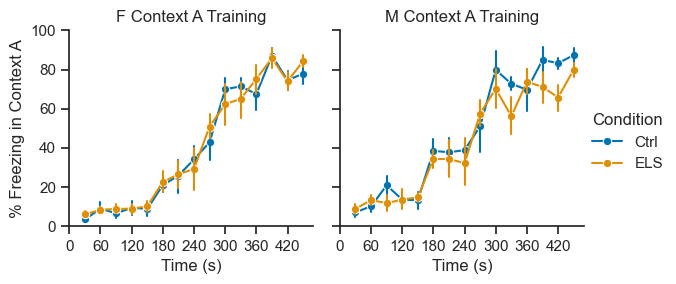

In [26]:
g = sns.FacetGrid(data = A_train_subset,col= 'Sex', hue = 'Condition',palette = 'colorblind')
g.map_dataframe(sns.lineplot,
                x = 'Time(s)', 
                y = 'PcentFreezing',
                estimator='mean',
                ci = 68, #for normally distributed data, a 68% CI will correspond to SEM
                marker = 'o',
                err_style = 'bars')
g.set_axis_labels('Time (s)', '% Freezing in Context A')
g.set_titles(col_template="{col_name} Context A Training", row_template="{row_name}")
g.set(ylim=(0, 100), xlim=(0,470), xticks= np.arange(0, 470, 60))
g.add_legend()

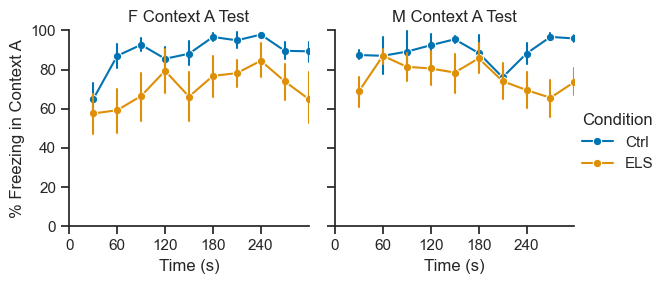

In [27]:
g2 = sns.FacetGrid(data = A_test_subset,col= 'Sex', hue = 'Condition',palette = 'colorblind')
g2.map_dataframe(sns.lineplot,
                x = 'Time(s)', 
                y = 'PcentFreezing',
                estimator='mean',
                ci = 68, #for normally distributed data, a 68% CI will correspond to SEM
                marker = 'o',
                err_style = 'bars')
g2.set_axis_labels('Time (s)', '% Freezing in Context A')
g2.set_titles(col_template="{col_name} Context A Test", row_template="{row_name}")
g2.set(ylim=(0, 100), xlim=(0,300), xticks= np.arange(0, 300, 60))
g2.add_legend()

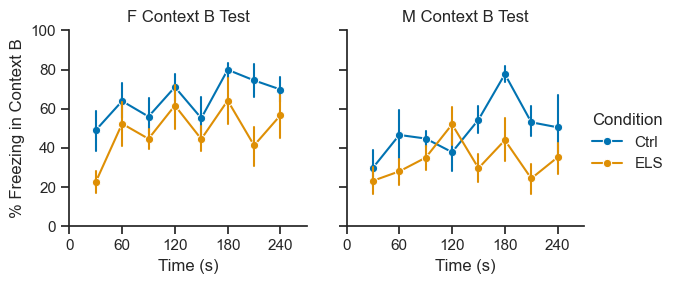

In [28]:
g3 = sns.FacetGrid(data = B_test_subset,col= 'Sex', hue = 'Condition',palette = 'colorblind')
g3.map_dataframe(sns.lineplot,
                x = 'Time(s)', 
                y = 'PcentFreezing',
                estimator='mean',
                ci = 68, #for normally distributed data, a 68% CI will correspond to SEM
                marker = 'o',
                err_style = 'bars')
g3.set_axis_labels('Time (s)', '% Freezing in Context B')
g3.set_titles(col_template="{col_name} Context B Test", row_template="{row_name}")
g3.set(ylim=(0, 100), xlim=(0,270), xticks= np.arange(0, 270, 60))
g3.add_legend()